### Task03：特征工程&特征选择（3天）

https://github.com/datawhalechina/team-learning/blob/master/数据竞赛（房租预测）/3_特征工程.ipynb

使用3种以上特征选择的方法，附上代码，最终效果截图

<b>特征工程</b>

数据和特征决定了机器学习的上限，而模型和算法只是逼近这个上限而已。那特征工程到底是什么呢？顾名思义，其本质是一项工程活动，目的是最大限度地从原始数据中提取特征以供算法和模型使用。so，想要获得一个比较好的分数，特征工程是十分重要的。那么数据清洗之后，特征工程该如何下手呢？由于不同的业务特征工程千差万别，在这里，只给一些思路，一些具体的特征工程方法，大家自己摸索。

- 房间总数
  - 根据房型信息抽取出更细的信息，然后可以组合
- 每平方均价
  - 根据租房信息可以求得每平方的均价
- 根据小区信息groupby
  - 同一个小区的租房信息相差不大，可以根据小区
- 聚类特征
  - 使用sklearn.mixture.GaussianMixture做聚类特征
- Word2vec特征
  - 将类别特征使用w2v构建特征（思路：将每一个样本的类别特征够造成一个句子，然后使用word2vec提取特征之间的相关关系）
- OneHotEncoder、labelencoder
  - 过大量级值取log平滑（针对线性模型有效）


<b>特征选择</b>

- Filter
  - 相关系数法
  - 卡方检验
- Wrapper
  - 递归特征消除法(RFE)
- Embedded
  - 基于惩罚项的特征选择法
  - 基于树模型的特征选择法
- baseline
  - 任选一个模型套用，得到baseline。对比任务二使用的模型结果的得分情况。

In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pylab as plt
from sklearn.ensemble import IsolationForest
# from pylab import *
# fname = r"/home/ach/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/SimHei.ttf"
# myfont = FontPro
train = pd.read_csv('./数据集/train_data.csv')
test = pd.read_csv('./数据集/test_a.csv')
# target_test = test.pop('tradeMoney')
# pop函数进行类似于栈的ｐｏｐ，弹出并删除某一个值
# target_train = train.pop('tradeMoney')
# target_test = test

In [2]:
# 对ｔｒａｉｎ进行数据清洗
# 使用第二天的代码
# 改进先不删除，不ｃｏｄｅｒ，最后一起ｃｏｄｅｒ
def preprocessingData(data):
    # 填充缺失值
    data['rentType'][data['rentType'] == '--'] = '未知方式'
    
#     # 转换object类型数据
#     columns = ['rentType','communityName','houseType', 'houseFloor', 'houseToward', 'houseDecoration',  'region', 'plate']
    
#     for feature in columns:
#         data[feature] = LabelEncoder().fit_transform(data[feature])

    # 将buildYear列转换为整型数据
    buildYearmean = pd.DataFrame(data[data['buildYear'] != '暂无信息']['buildYear'].mode())
    data.loc[data[data['buildYear'] == '暂无信息'].index, 'buildYear'] = buildYearmean.iloc[0, 0]
    data['buildYear'] = data['buildYear'].astype('int')

    # 处理pv和uv的空值
    data['pv'].fillna(data['pv'].mean(), inplace=True)
    data['uv'].fillna(data['uv'].mean(), inplace=True)
    data['pv'] = data['pv'].astype('int')
    data['uv'] = data['uv'].astype('int')

#     # 分割交易时间
#     def month(x):
#         month = int(x.split('/')[1])
#         return month
#     def day(x):
#         day = int(x.split('/')[2])
#         return day
#     data['month'] = data['tradeTime'].apply(lambda x: month(x))
#     data['day'] = data['tradeTime'].apply(lambda x: day(x))
    
#     # 去掉部分特征
#     data.drop('city', axis=1, inplace=True)
#     data.drop('tradeTime', axis=1, inplace=True)
#     data.drop('ID', axis=1, inplace=True)
    return data

train = preprocessingData(train)
test = preprocessingData(test)

In [3]:
# clean data
def IF_drop(train):
    IForest = IsolationForest(contamination=0.01)
    IForest.fit(train["tradeMoney"].values.reshape(-1,1))
    y_pred = IForest.predict(train["tradeMoney"].values.reshape(-1,1))
    drop_index = train.loc[y_pred==-1].index
    print(drop_index)
    train.drop(drop_index,inplace=True)# 有删除
    return train

train = IF_drop(train)


/home/ach/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


Int64Index([   62,    69,   128,   131,   246,   261,   266,   297,   308,
              313,
            ...
            39224, 39228, 39319, 39347, 39352, 39434, 39563, 41080, 41083,
            41233],
           dtype='int64', length=402)


In [4]:
def dropData(train):
    # 丢弃部分异常值
    train = train[train.area <= 200]
    train = train[(train.tradeMoney <=16000) & (train.tradeMoney >=700)]
    train.drop(train[(train['totalFloor'] == 0)].index, inplace=True)
    return train  
#数据集异常值处理
train = dropData(train)
def cleanData(data):
    data.drop(data[(data['region']=='RG00001') & (data['tradeMoney']<1000)&(data['area']>50)].index,inplace=True)
    data.drop(data[(data['region']=='RG00001') & (data['tradeMoney']>25000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00001') & (data['area']>250)&(data['tradeMoney']<20000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00001') & (data['area']>400)&(data['tradeMoney']>50000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00001') & (data['area']>100)&(data['tradeMoney']<2000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00002') & (data['area']<100)&(data['tradeMoney']>60000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00003') & (data['area']<300)&(data['tradeMoney']>30000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00003') & (data['tradeMoney']<500)&(data['area']<50)].index,inplace=True)
    data.drop(data[(data['region']=='RG00003') & (data['tradeMoney']<1500)&(data['area']>100)].index,inplace=True)
    data.drop(data[(data['region']=='RG00003') & (data['tradeMoney']<2000)&(data['area']>300)].index,inplace=True)
    data.drop(data[(data['region']=='RG00003') & (data['tradeMoney']>5000)&(data['area']<20)].index,inplace=True)
    data.drop(data[(data['region']=='RG00003') & (data['area']>600)&(data['tradeMoney']>40000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00004') & (data['tradeMoney']<1000)&(data['area']>80)].index,inplace=True)
    data.drop(data[(data['region']=='RG00006') & (data['tradeMoney']<200)].index,inplace=True)
    data.drop(data[(data['region']=='RG00005') & (data['tradeMoney']<2000)&(data['area']>180)].index,inplace=True)
    data.drop(data[(data['region']=='RG00005') & (data['tradeMoney']>50000)&(data['area']<200)].index,inplace=True)
    data.drop(data[(data['region']=='RG00006') & (data['area']>200)&(data['tradeMoney']<2000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00007') & (data['area']>100)&(data['tradeMoney']<2500)].index,inplace=True)
    data.drop(data[(data['region']=='RG00010') & (data['area']>200)&(data['tradeMoney']>25000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00010') & (data['area']>400)&(data['tradeMoney']<15000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00010') & (data['tradeMoney']<3000)&(data['area']>200)].index,inplace=True)
    data.drop(data[(data['region']=='RG00010') & (data['tradeMoney']>7000)&(data['area']<75)].index,inplace=True)
    data.drop(data[(data['region']=='RG00010') & (data['tradeMoney']>12500)&(data['area']<100)].index,inplace=True)
    data.drop(data[(data['region']=='RG00004') & (data['area']>400)&(data['tradeMoney']>20000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00008') & (data['tradeMoney']<2000)&(data['area']>80)].index,inplace=True)
    data.drop(data[(data['region']=='RG00009') & (data['tradeMoney']>40000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00009') & (data['area']>300)].index,inplace=True)
    data.drop(data[(data['region']=='RG00009') & (data['area']>100)&(data['tradeMoney']<2000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00011') & (data['tradeMoney']<10000)&(data['area']>390)].index,inplace=True)
    data.drop(data[(data['region']=='RG00012') & (data['area']>120)&(data['tradeMoney']<5000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00013') & (data['area']<100)&(data['tradeMoney']>40000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00013') & (data['area']>400)&(data['tradeMoney']>50000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00013') & (data['area']>80)&(data['tradeMoney']<2000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00014') & (data['area']>300)&(data['tradeMoney']>40000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00014') & (data['tradeMoney']<1300)&(data['area']>80)].index,inplace=True)
    data.drop(data[(data['region']=='RG00014') & (data['tradeMoney']<8000)&(data['area']>200)].index,inplace=True)
    data.drop(data[(data['region']=='RG00014') & (data['tradeMoney']<1000)&(data['area']>20)].index,inplace=True)
    data.drop(data[(data['region']=='RG00014') & (data['tradeMoney']>25000)&(data['area']>200)].index,inplace=True)
    data.drop(data[(data['region']=='RG00014') & (data['tradeMoney']<20000)&(data['area']>250)].index,inplace=True)
    data.drop(data[(data['region']=='RG00005') & (data['tradeMoney']>30000)&(data['area']<100)].index,inplace=True)
    data.drop(data[(data['region']=='RG00005') & (data['tradeMoney']<50000)&(data['area']>600)].index,inplace=True)
    data.drop(data[(data['region']=='RG00005') & (data['tradeMoney']>50000)&(data['area']>350)].index,inplace=True)
    data.drop(data[(data['region']=='RG00006') & (data['tradeMoney']>4000)&(data['area']<100)].index,inplace=True)
    data.drop(data[(data['region']=='RG00006') & (data['tradeMoney']<600)&(data['area']>100)].index,inplace=True)
    data.drop(data[(data['region']=='RG00006') & (data['area']>165)].index,inplace=True)
    data.drop(data[(data['region']=='RG00012') & (data['tradeMoney']<800)&(data['area']<30)].index,inplace=True)
    data.drop(data[(data['region']=='RG00007') & (data['tradeMoney']<1100)&(data['area']>50)].index,inplace=True)
    data.drop(data[(data['region']=='RG00004') & (data['tradeMoney']>8000)&(data['area']<80)].index,inplace=True)
    data.loc[(data['region']=='RG00002')&(data['area']>50)&(data['rentType']=='合租'),'rentType']='整租'
    data.loc[(data['region']=='RG00014')&(data['rentType']=='合租')&(data['area']>60),'rentType']='整租'
    data.drop(data[(data['region']=='RG00008')&(data['tradeMoney']>15000)&(data['area']<110)].index,inplace=True)
    data.drop(data[(data['region']=='RG00008')&(data['tradeMoney']>20000)&(data['area']>110)].index,inplace=True)
    data.drop(data[(data['region']=='RG00008')&(data['tradeMoney']<1500)&(data['area']<50)].index,inplace=True)
    data.drop(data[(data['region']=='RG00008')&(data['rentType']=='合租')&(data['area']>50)].index,inplace=True)
    data.drop(data[(data['region']=='RG00015') ].index,inplace=True)
    data.reset_index(drop=True, inplace=True)
    return data
train = cleanData(train)

In [5]:
train

,ID,area,rentType,houseType,houseFloor,totalFloor,houseToward,houseDecoration,communityName,city,...,landTotalPrice,landMeanPrice,totalWorkers,newWorkers,residentPopulation,pv,uv,lookNum,tradeTime,tradeMoney
0,100309852,68.06,未知方式,2室1厅1卫,低,16,暂无数据,其他,XQ00051,SH,...,0,0.0000,28248,614,111546,1124,284,0,2018/11/28,2000.0
1,100307942,125.55,未知方式,3室2厅2卫,中,14,暂无数据,简装,XQ00130,SH,...,0,0.0000,14823,148,157552,701,22,1,2018/12/16,2000.0
2,100307764,132.00,未知方式,3室2厅2卫,低,32,暂无数据,其他,XQ00179,SH,...,0,0.0000,77645,520,131744,57,20,1,2018/12/22,16000.0
3,100306518,57.00,未知方式,1室1厅1卫,中,17,暂无数据,精装,XQ00313,SH,...,332760000,3080.0331,8750,1665,253337,888,279,9,2018/12/21,1600.0
4,100305262,129.00,未知方式,3室2厅3卫,低,2,暂无数据,毛坯,XQ01257,SH,...,0,0.0000,800,117,125309,2038,480,0,2018/11/18,2900.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40129,100000438,10.00,合租,4室1厅1卫,高,11,北,精装,XQ01209,SH,...,573070000,4313.0100,20904,0,245872,29635,2662,0,2018/2/5,2190.0
40130,100000201,7.10,合租,3室1厅1卫,中,6,北,精装,XQ00853,SH,...,0,0.0000,4370,0,306857,28213,2446,0,2018/1/22,2090.0
40131,100000198,9.20,合租,4室1厅1卫,高,18,北,精装,XQ00852,SH,...,0,0.0000,4370,0,306857,19231,2016,0,2018/2/8,3190.0
40132,100000182,14.10,合租,4室1厅1卫,低,8,北,精装,XQ00791,SH,...,0,0.0000,4370,0,306857,17471,2554,0,2018/3/22,2460.0


In [6]:
test

,ID,area,rentType,houseType,houseFloor,totalFloor,houseToward,houseDecoration,communityName,city,...,tradeLandArea,landTotalPrice,landMeanPrice,totalWorkers,newWorkers,residentPopulation,pv,uv,lookNum,tradeTime
0,100000079,36.54,未知方式,1室1厅1卫,高,21,西北,其他,XQ03867,SH,...,0.00,0,0.0,41503,319,301635,1601,397,2,2018/10/25
1,100000138,64.00,未知方式,2室1厅1卫,高,11,南北,其他,XQ00821,SH,...,0.00,0,0.0,4370,0,306857,21123,3066,0,2018/8/19
2,100000192,98.00,未知方式,3室1厅1卫,高,6,暂无数据,精装,XQ00842,SH,...,0.00,0,0.0,4370,0,306857,17471,2554,0,2018/3/4
3,100000200,43.45,未知方式,1室1厅1卫,高,6,暂无数据,其他,XQ00786,SH,...,0.00,0,0.0,4370,0,306857,19231,2016,0,2018/2/3
4,100000430,92.00,未知方式,2室2厅1卫,高,6,暂无数据,其他,XQ01201,SH,...,237828.35,1078790000,4536.0,20904,0,245872,26189,2957,0,2018/3/14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2464,100314527,66.00,未知方式,2室1厅1卫,低,5,南,其他,XQ02427,SH,...,0.00,0,0.0,28546,724,371900,1181,271,7,2018/12/31
2465,100314532,30.00,未知方式,1室0厅1卫,中,5,南,其他,XQ01110,SH,...,0.00,0,0.0,855400,40536,161754,247,35,1,2018/12/31
2466,100314560,39.36,未知方式,1室1厅1卫,高,6,南,其他,XQ01093,SH,...,0.00,0,0.0,855400,40536,161754,247,35,16,2018/12/31
2467,100314660,57.00,未知方式,2室0厅1卫,中,7,南,其他,XQ01108,SH,...,0.00,0,0.0,855400,40536,161754,247,35,4,2018/12/23


# 房间众数特征进行分类

# 将houseType转为'Room'，'Hall'，'Bath'
def Room(x):
    Room = int(x.split('室')[0])
    return Room
def Hall(x):
    Hall = int(x.split("室")[1].split("厅")[0])
    return Hall
def Bath(x):
    Bath = int(x.split("室")[1].split("厅")[1].split("卫")[0])
    return Bath

data['Room'] = data['houseType'].apply(lambda x: Room(x))
data['Hall'] = data['houseType'].apply(lambda x: Hall(x))
data['Bath'] = data['houseType'].apply(lambda x: Bath(x))
data['Room_Bath'] = (data['Bath']+1) / (data['Room']+1)
#这个我们先不运行，等下一起运行

# 统计特征
    #计算均值
    gp = train.groupby(by)[fea].mean()
    #计算中位数
    gp = train.groupby(by)[fea].median()
    #计算方差
    gp = train.groupby(by)[fea].std()
    #计算最大值
    gp = train.groupby(by)[fea].max()
    #计算最小值
    gp = train.groupby(by)[fea].min()
    #计算出现次数
    gp = train.groupby(by)[fea].size()
# 这些是统计特征的代码

In [23]:
temp = train.groupby('communityName')['area'].agg({'com_area_mean': 'mean', 'com_area_std': 'std'})
# 啥也别说了，鼓掌吧`
#解释　ａｇｇ函数通常和ｇｒｏｕｐｂｙ函数进行一起使用，主要表现为分组聚合的样子

In [8]:
temp

,com_area_mean,com_area_std
communityName,,
XQ00001,100.170000,NaN
XQ00002,39.310000,0.000000
XQ00003,59.480000,NaN
XQ00004,120.030000,16.674373
XQ00005,29.000000,12.072403
...,...,...
XQ04231,116.480000,NaN
XQ04232,52.079231,22.787946
XQ04233,23.027500,20.138281


In [7]:
target_train = train.pop('tradeMoney')#这是精髓，将这一列去掉，好连接
train

,ID,area,rentType,houseType,houseFloor,totalFloor,houseToward,houseDecoration,communityName,city,...,tradeLandArea,landTotalPrice,landMeanPrice,totalWorkers,newWorkers,residentPopulation,pv,uv,lookNum,tradeTime
0,100309852,68.06,未知方式,2室1厅1卫,低,16,暂无数据,其他,XQ00051,SH,...,0.0,0,0.0000,28248,614,111546,1124,284,0,2018/11/28
1,100307942,125.55,未知方式,3室2厅2卫,中,14,暂无数据,简装,XQ00130,SH,...,0.0,0,0.0000,14823,148,157552,701,22,1,2018/12/16
2,100307764,132.00,未知方式,3室2厅2卫,低,32,暂无数据,其他,XQ00179,SH,...,0.0,0,0.0000,77645,520,131744,57,20,1,2018/12/22
3,100306518,57.00,未知方式,1室1厅1卫,中,17,暂无数据,精装,XQ00313,SH,...,108037.8,332760000,3080.0331,8750,1665,253337,888,279,9,2018/12/21
4,100305262,129.00,未知方式,3室2厅3卫,低,2,暂无数据,毛坯,XQ01257,SH,...,0.0,0,0.0000,800,117,125309,2038,480,0,2018/11/18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40129,100000438,10.00,合租,4室1厅1卫,高,11,北,精装,XQ01209,SH,...,132870.0,573070000,4313.0100,20904,0,245872,29635,2662,0,2018/2/5
40130,100000201,7.10,合租,3室1厅1卫,中,6,北,精装,XQ00853,SH,...,0.0,0,0.0000,4370,0,306857,28213,2446,0,2018/1/22
40131,100000198,9.20,合租,4室1厅1卫,高,18,北,精装,XQ00852,SH,...,0.0,0,0.0000,4370,0,306857,19231,2016,0,2018/2/8
40132,100000182,14.10,合租,4室1厅1卫,低,8,北,精装,XQ00791,SH,...,0.0,0,0.0000,4370,0,306857,17471,2554,0,2018/3/22


In [2]:
# # 房间众数特征进行分类
# def newfeature(data):
# # 将houseType转为'Room'，'Hall'，'Bath'
#     def Room(x):
#         Room = int(x.split('室')[0])
#         return Room
#     def Hall(x):
#         Hall = int(x.split("室")[1].split("厅")[0])
#         return Hall
#     def Bath(x):
#         Bath = int(x.split("室")[1].split("厅")[1].split("卫")[0])
#         return Bath

#     data['Room'] = data['houseType'].apply(lambda x: Room(x))
#     data['Hall'] = data['houseType'].apply(lambda x: Hall(x))
#     data['Bath'] = data['houseType'].apply(lambda x: Bath(x))
#     data['Room_Bath'] = (data['Bath']+1) / (data['Room']+1)
#     return data
# #这个我们先不运行，等下一起运行

In [26]:
# print(newfeature(train))

              ID    area rentType houseType houseFloor  totalFloor  \
0      100309852   68.06     未知方式    2室1厅1卫          低          16   
1      100307942  125.55     未知方式    3室2厅2卫          中          14   
2      100307764  132.00     未知方式    3室2厅2卫          低          32   
3      100306518   57.00     未知方式    1室1厅1卫          中          17   
4      100305262  129.00     未知方式    3室2厅3卫          低           2   
...          ...     ...      ...       ...        ...         ...   
41435  100000438   10.00       合租    4室1厅1卫          高          11   
41436  100000201    7.10       合租    3室1厅1卫          中           6   
41437  100000198    9.20       合租    4室1厅1卫          高          18   
41438  100000182   14.10       合租    4室1厅1卫          低           8   
41439  100000041   33.50     未知方式    1室1厅1卫          中          19   

      houseToward houseDecoration communityName city  ... newWorkers  \
0            暂无数据              其他       XQ00051   SH  ...        614   
1            暂无

In [11]:
# data_train = newfeature(train)
# # 回归图,area,tradeMoney
# # col表示根据指定属性在列上进行分类
# #hue用于分类
# # sharex：是否共享x刻度
# #
# plt.figure(figsize=(9,6))
# tr = data_train[data_train['area']<=800]
# g= sns.lmplot('area','Room',hue='rentType', data=tr[tr['rentType']!="未知方式"])

# plt.tight_layout()
# plt.show()

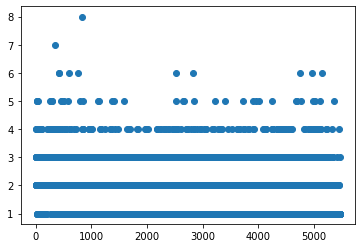

2    2475
1    1891
3     900
4     158
5      37
6       9
7       1
8       1
Name: Room, dtype: int64


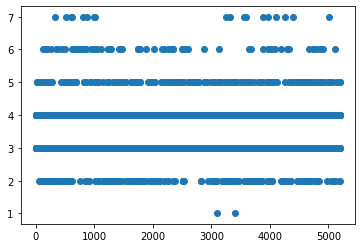

3    2740
4    1964
2     209
5     203
6      68
7      18
1       2
Name: Room, dtype: int64


In [36]:
tr1 = data_train[data_train['rentType']=='整租']['Room']
plt.scatter(range(0,len(tr1)),tr1)
plt.show()
print(tr1.value_counts())
tr2 = data_train[data_train['rentType']=='合租']['Room']
plt.scatter(range(0,len(tr2)),tr2)
plt.show()
print(tr2.value_counts())

In [37]:
#得到条件data.loc[(data['rentType'] == '未知方式') & (data['Room'] <= 1), 'rentType'] = '整租'

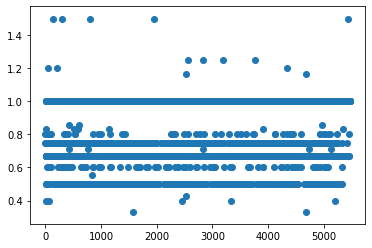

0.666667    2320
1.000000    2099
0.750000     490
0.500000     395
0.600000      81
0.800000      50
0.833333       6
1.500000       5
0.400000       5
0.714286       5
1.250000       4
1.200000       3
0.857143       3
1.166667       2
0.333333       2
0.555556       1
0.428571       1
Name: Room_Bath, dtype: int64


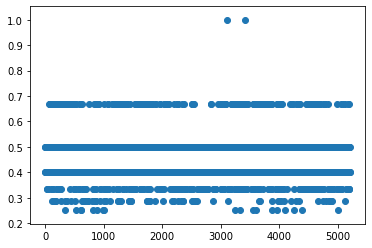

0.500000    2740
0.400000    1964
0.666667     209
0.333333     203
0.285714      68
0.250000      18
1.000000       2
Name: Room_Bath, dtype: int64


In [39]:
tr1 = data_train[data_train['rentType']=='整租']['Room_Bath']
plt.scatter(range(0,len(tr1)),tr1)
plt.show()
print(tr1.value_counts())
tr2 = data_train[data_train['rentType']=='合租']['Room_Bath']
plt.scatter(range(0,len(tr2)),tr2)
plt.show()
print(tr2.value_counts())

In [40]:
# data.loc[(data['rentType'] == '未知方式') & (data['Room_Bath'] > 1), 'rentType'] = '合租'
# 可以得到第二句话

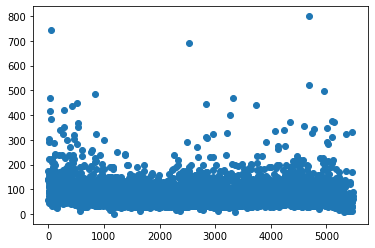

90.00    49
89.00    40
88.00    30
70.00    24
85.00    22
         ..
56.03     1
34.46     1
60.69     1
63.82     1
64.02     1
Name: area, Length: 3449, dtype: int64


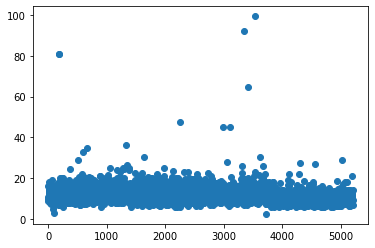

10.00    195
12.00    169
13.00    152
14.00    131
15.00    129
        ... 
9.89       1
14.05      1
7.98       1
16.67      1
47.40      1
Name: area, Length: 518, dtype: int64


In [41]:
tr1 = data_train[data_train['rentType']=='整租']['area']
plt.scatter(range(0,len(tr1)),tr1)
plt.show()
print(tr1.value_counts())
tr2 = data_train[data_train['rentType']=='合租']['area']
plt.scatter(range(0,len(tr2)),tr2)
plt.show()
print(tr2.value_counts())

In [ ]:
# data.loc[(data['rentType'] == '未知方式') & (data['Room'] > 1) & (data['area'] < 50), 'rentType'] = '合租'
# 可以得到第三句话

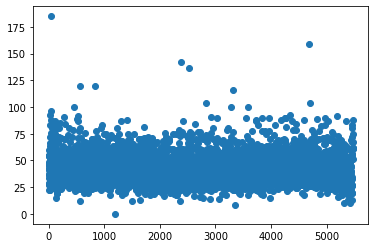

44.0     246
42.0     239
45.0     234
33.0     192
35.0     191
        ... 
82.0       1
142.0      1
159.0      1
185.0      1
137.0      1
Length: 93, dtype: int64


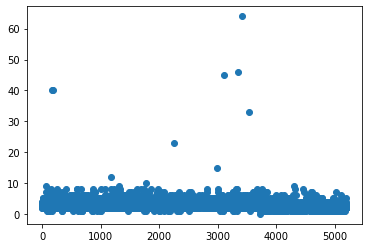

3.0     1923
4.0     1315
2.0     1259
5.0      382
1.0      146
6.0       94
7.0       46
8.0       25
9.0        3
40.0       2
33.0       1
12.0       1
10.0       1
15.0       1
64.0       1
0.0        1
45.0       1
23.0       1
46.0       1
dtype: int64


In [44]:
tr1 = data_train[data_train['rentType']=='整租']['area']//data_train[data_train['rentType']=='整租']['Room']
plt.scatter(range(0,len(tr1)),tr1)
plt.show()
print(tr1.value_counts())
tr2 = data_train[data_train['rentType']=='合租']['area']//data_train[data_train['rentType']=='合租']['Room']
plt.scatter(range(0,len(tr2)),tr2)
plt.show()
print(tr2.value_counts())

In [4]:
# data.loc[(data['rentType'] == '未知方式') & (data['area'] / data['Room'] < 20), 'rentType'] = '合租'
# 第四句话


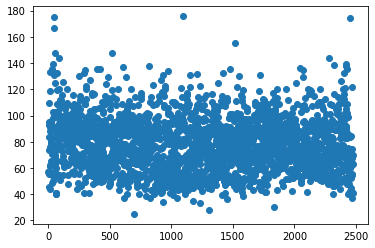

90.00     27
89.00     23
88.00     22
85.00     18
70.00     17
          ..
87.90      1
48.10      1
45.97      1
101.70     1
58.01      1
Name: area, Length: 1700, dtype: int64


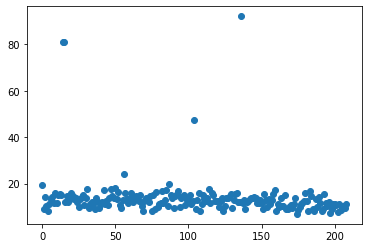

15.00    8
10.00    7
13.70    7
11.50    6
14.00    6
        ..
9.17     1
24.03    1
16.60    1
8.68     1
8.99     1
Name: area, Length: 108, dtype: int64


In [53]:
tr1 = data_train[(data_train['rentType']=='整租')&(data_train['Room']==2)]['area']
plt.scatter(range(0,len(tr1)),tr1)
plt.show()
print(tr1.value_counts())
tr2 = data_train[(data_train['rentType']=='合租')&(data_train['Room']==2)]['area']
plt.scatter(range(0,len(tr2)),tr2)
plt.show()
print(tr2.value_counts())

In [5]:
# data.loc[(data['rentType'] == '未知方式') & (data['area'] <= 50) & (data['Room'] == 2), 'rentType'] = '合租'
# data.loc[(data['rentType'] == '未知方式') & (data['area'] > 60) & (data['Room'] == 2), 'rentType'] = '整租'
# 可以理解

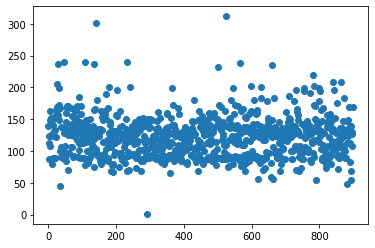

89.00     16
90.00     15
118.00    10
88.00      8
103.00     8
          ..
100.28     1
136.25     1
113.17     1
133.88     1
111.08     1
Name: area, Length: 674, dtype: int64


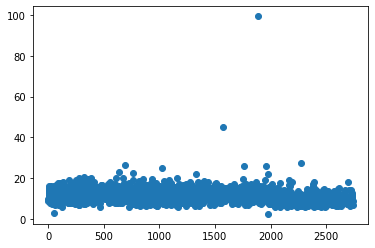

10.00    91
12.00    87
13.00    84
14.00    78
15.00    58
         ..
11.86     1
13.17     1
19.15     1
13.14     1
13.48     1
Name: area, Length: 348, dtype: int64


In [61]:
tr1 = data_train[(data_train['rentType']=='整租')&(data_train['Room']==3)]['area']
plt.scatter(range(0,len(tr1)),tr1)
plt.show()
print(tr1.value_counts())
tr2 = data_train[(data_train['rentType']=='合租')&(data_train['Room']==3)]['area']
plt.scatter(range(0,len(tr2)),tr2)
plt.show()
print(tr2.value_counts())

In [ ]:
# data.loc[(data['rentType'] == '未知方式') & (data['area'] <= 60) & (data['Room'] == 3), 'rentType'] = '合租'
# data.loc[(data['rentType'] == '未知方式') & (data['area'] > 60) & (data['Room'] == 3), 'rentType'] = '整租'
# data.loc[(data['rentType'] == '未知方式') & (data['area'] >= 100) & (data['Room'] > 3), 'rentType'] = '整租'
#可以明白

In [6]:
# # 填充租房类型
# data.loc[(data['rentType'] == '未知方式') & (data['Room'] <= 1), 'rentType'] = '整租'

# # print(data.loc[(data['rentType']=='未知方式')&(data['Room_Bath']>1),'rentType'])
# data.loc[(data['rentType'] == '未知方式') & (data['Room_Bath'] > 1), 'rentType'] = '合租'
# data.loc[(data['rentType'] == '未知方式') & (data['Room'] > 1) & (data['area'] < 50), 'rentType'] = '合租'
# data.loc[(data['rentType'] == '未知方式') & (data['area'] / data['Room'] < 20), 'rentType'] = '合租'
# # data.loc[(data['rentType']=='未知方式')&(data['area']>60),'rentType']='合租'
# data.loc[(data['rentType'] == '未知方式') & (data['area'] <= 50) & (data['Room'] == 2), 'rentType'] = '合租'
# data.loc[(data['rentType'] == '未知方式') & (data['area'] > 60) & (data['Room'] == 2), 'rentType'] = '整租'
# data.loc[(data['rentType'] == '未知方式') & (data['area'] <= 60) & (data['Room'] == 3), 'rentType'] = '合租'
# data.loc[(data['rentType'] == '未知方式') & (data['area'] > 60) & (data['Room'] == 3), 'rentType'] = '整租'
# data.loc[(data['rentType'] == '未知方式') & (data['area'] >= 100) & (data['Room'] > 3), 'rentType'] = '整租'


# 合并特征
第一个合并特征：交通工具，ｓｕｂｗａｙ或者ｂｕｓ，从经验理解是要求ｓｕｂｗａｙ的占比更高，所以使用特征


#第二个合并特征，学校，国际学校，公立学校，私立学校，国际学校比较受欢迎，所以国际学校的权重会更大一点
#同理，三个特征，就是商城了，这里都是均等看的
#第四个特征就是其他特征，这里我们就把ｐａｒｋ开的高一点

In [ ]:
# data['trainsportNum'] = 5 * data['subwayStationNum'] / data['subwayStationNum'].mean() + data['busStationNum'] / \
#                                                                                          data[
#                                                                                              'busStationNum'].mean()
# data['all_SchoolNum'] = 2 * data['interSchoolNum'] / data['interSchoolNum'].mean() + data['schoolNum'] / data[
#     'schoolNum'].mean() \
#                         + data['privateSchoolNum'] / data['privateSchoolNum'].mean()
# data['all_hospitalNum'] = 2 * data['hospitalNum'] / data['hospitalNum'].mean() + \
#                           data['drugStoreNum'] / data['drugStoreNum'].mean()
# data['all_mall'] = data['mallNum'] / data['mallNum'].mean() + \
#                    data['superMarketNum'] / data['superMarketNum'].mean()
# data['otherNum'] = data['gymNum'] / data['gymNum'].mean() + data['bankNum'] / data['bankNum'].mean() + \
#                    data['shopNum'] / data['shopNum'].mean() + 2 * data['parkNum'] / data['parkNum'].mean()

# data.drop(['subwayStationNum', 'busStationNum',
#            'interSchoolNum', 'schoolNum', 'privateSchoolNum',
#            'hospitalNum', 'drugStoreNum', 'mallNum', 'superMarketNum', 'gymNum', 'bankNum', 'shopNum', 'parkNum'],
#           axis=1, inplace=True)

In [ ]:
# def month(x):
#     month = int(x.split('/')[1])
#     return month
# # def day(x):
# #     day = int(x.split('/')[2])
# #     return day
# # 结果变差

# # 分割交易时间
# # data['year']=data['tradeTime'].apply(lambda x:year(x))
# data['month'] = data['tradeTime'].apply(lambda x: month(x))
# #销量的月份提出来

In [8]:
def newfeature(data):
    # 将houseType转为'Room'，'Hall'，'Bath'
    def Room(x):
        Room = int(x.split('室')[0])
        return Room
    def Hall(x):
        Hall = int(x.split("室")[1].split("厅")[0])
        return Hall
    def Bath(x):
        Bath = int(x.split("室")[1].split("厅")[1].split("卫")[0])
        return Bath

    data['Room'] = data['houseType'].apply(lambda x: Room(x))
    data['Hall'] = data['houseType'].apply(lambda x: Hall(x))
    data['Bath'] = data['houseType'].apply(lambda x: Bath(x))
    data['Room_Bath'] = (data['Bath']+1) / (data['Room']+1)
    # 填充租房类型
    data.loc[(data['rentType'] == '未知方式') & (data['Room'] <= 1), 'rentType'] = '整租'
    # print(data.loc[(data['rentType']=='未知方式')&(data['Room_Bath']>1),'rentType'])
    data.loc[(data['rentType'] == '未知方式') & (data['Room_Bath'] > 1), 'rentType'] = '合租'
    data.loc[(data['rentType'] == '未知方式') & (data['Room'] > 1) & (data['area'] < 50), 'rentType'] = '合租'
    data.loc[(data['rentType'] == '未知方式') & (data['area'] / data['Room'] < 20), 'rentType'] = '合租'
    # data.loc[(data['rentType']=='未知方式')&(data['area']>60),'rentType']='合租'
    data.loc[(data['rentType'] == '未知方式') & (data['area'] <= 50) & (data['Room'] == 2), 'rentType'] = '合租'
    data.loc[(data['rentType'] == '未知方式') & (data['area'] > 60) & (data['Room'] == 2), 'rentType'] = '整租'
    data.loc[(data['rentType'] == '未知方式') & (data['area'] <= 60) & (data['Room'] == 3), 'rentType'] = '合租'
    data.loc[(data['rentType'] == '未知方式') & (data['area'] > 60) & (data['Room'] == 3), 'rentType'] = '整租'
    data.loc[(data['rentType'] == '未知方式') & (data['area'] >= 100) & (data['Room'] > 3), 'rentType'] = '整租'

    # data.drop('Room_Bath', axis=1, inplace=True)
    # 提升0.0001
    def month(x):
        month = int(x.split('/')[1])
        return month
    # def day(x):
    #     day = int(x.split('/')[2])
    #     return day
    # 结果变差

    # 分割交易时间
    # data['year']=data['tradeTime'].apply(lambda x:year(x))
    data['month'] = data['tradeTime'].apply(lambda x: month(x))
    # data['day'] = data['tradeTime'].apply(lambda x: day(x))# 结果变差
    #     data['pv/uv'] = data['pv'] / data['uv']
    #     data['房间总数'] = data['室'] + data['厅'] + data['卫']

    # 合并部分配套设施特征
    data['trainsportNum'] = 5 * data['subwayStationNum'] / data['subwayStationNum'].mean() + data['busStationNum'] / \
                                                                                             data[
                                                                                                 'busStationNum'].mean()
    data['all_SchoolNum'] = 2 * data['interSchoolNum'] / data['interSchoolNum'].mean() + data['schoolNum'] / data[
        'schoolNum'].mean() \
                            + data['privateSchoolNum'] / data['privateSchoolNum'].mean()
    data['all_hospitalNum'] = 2 * data['hospitalNum'] / data['hospitalNum'].mean() + \
                              data['drugStoreNum'] / data['drugStoreNum'].mean()
    data['all_mall'] = data['mallNum'] / data['mallNum'].mean() + \
                       data['superMarketNum'] / data['superMarketNum'].mean()
    data['otherNum'] = data['gymNum'] / data['gymNum'].mean() + data['bankNum'] / data['bankNum'].mean() + \
                       data['shopNum'] / data['shopNum'].mean() + 2 * data['parkNum'] / data['parkNum'].mean()

    data.drop(['subwayStationNum', 'busStationNum',
               'interSchoolNum', 'schoolNum', 'privateSchoolNum',
               'hospitalNum', 'drugStoreNum', 'mallNum', 'superMarketNum', 'gymNum', 'bankNum', 'shopNum', 'parkNum'],
              axis=1, inplace=True)
    # 提升0.0005
    
#     data['houseType_1sumcsu']=data['Bath'].map(lambda x:str(x))+data['month'].map(lambda x:str(x))
#     data['houseType_2sumcsu']=data['Bath'].map(lambda x:str(x))+data['communityName']
#     data['houseType_3sumcsu']=data['Bath'].map(lambda x:str(x))+data['plate']
    
    data.drop('houseType', axis=1, inplace=True)
    data.drop('tradeTime', axis=1, inplace=True)
    
    data["area"] = data["area"].astype(int)


    # categorical_feats = ['rentType', 'houseFloor', 'houseToward', 'houseDecoration', 'communityName','region', 'plate']
    categorical_feats = ['rentType', 'houseFloor', 'houseToward', 'houseDecoration',  'region', 'plate','cluster']

    return data, categorical_feats
train,train_categorical = newfeature(train)
test,test_categorical = newfeature(test)
#初步特征融合

# 计算统计特征

In [9]:
#计算统计特征
def featureCount(train,test):
    train['data_type'] = 0
    test['data_type'] = 1
    data = pd.concat([train, test], axis=0, join='outer')
    def feature_count(data, features=[]):
        new_feature = 'count'
        for i in features:
            new_feature += '_' + i
        temp = data.groupby(features).size().reset_index().rename(columns={0: new_feature})
        data = data.merge(temp, 'left', on=features)
        return data

    data = feature_count(data, ['communityName'])
    data = feature_count(data, ['buildYear'])
    data = feature_count(data, ['totalFloor'])
    data = feature_count(data, ['communityName', 'totalFloor'])
    data = feature_count(data, ['communityName', 'newWorkers'])
    data = feature_count(data, ['communityName', 'totalTradeMoney'])
    new_train = data[data['data_type'] == 0]
    new_test = data[data['data_type'] == 1]
    new_train.drop('data_type', axis=1, inplace=True)
    new_test.drop(['data_type'], axis=1, inplace=True)
    return new_train, new_test
    
train, test = featureCount(train, test)

In [10]:
train

,ID,area,rentType,houseFloor,totalFloor,houseToward,houseDecoration,communityName,city,region,...,all_SchoolNum,all_hospitalNum,all_mall,otherNum,count_communityName,count_buildYear,count_totalFloor,count_communityName_totalFloor,count_communityName_newWorkers,count_communityName_totalTradeMoney
0,100309852,68,整租,低,16,暂无数据,其他,XQ00051,SH,RG00001,...,0.737777,0.668549,0.743700,2.248704,6,83,1168,4,1,1
1,100307942,125,整租,中,14,暂无数据,简装,XQ00130,SH,RG00002,...,0.537433,0.926561,1.250763,2.533496,11,1840,2251,7,1,1
2,100307764,132,整租,低,32,暂无数据,其他,XQ00179,SH,RG00002,...,2.556560,1.799236,0.999574,3.516671,25,5839,219,12,2,2
3,100306518,57,整租,中,17,暂无数据,精装,XQ00313,SH,RG00002,...,4.098679,5.124778,1.727126,3.853098,60,5839,1394,35,3,3
4,100305262,129,整租,低,2,暂无数据,毛坯,XQ01257,SH,RG00003,...,0.310058,0.361217,0.727053,1.934225,15,5839,61,4,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40129,100000438,10,合租,高,11,北,精装,XQ01209,SH,RG00002,...,3.271858,1.304978,2.293497,4.757167,23,1249,2972,6,22,4
40130,100000201,7,合租,中,6,北,精装,XQ00853,SH,RG00002,...,1.310190,3.959689,1.733904,4.665609,26,1441,16811,16,25,8
40131,100000198,9,合租,高,18,北,精装,XQ00852,SH,RG00002,...,1.310190,3.959689,1.733904,4.665609,106,951,3684,16,95,6
40132,100000182,14,合租,低,8,北,精装,XQ00791,SH,RG00002,...,1.310190,3.959689,1.733904,4.665609,3,738,662,2,3,3


In [11]:
train['data_type'] = 0
test['data_type'] = 1
data = pd.concat([train, test], axis=0, join='outer')

In [12]:
data

,ID,area,rentType,houseFloor,totalFloor,houseToward,houseDecoration,communityName,city,region,...,all_hospitalNum,all_mall,otherNum,count_communityName,count_buildYear,count_totalFloor,count_communityName_totalFloor,count_communityName_newWorkers,count_communityName_totalTradeMoney,data_type
0,100309852,68,整租,低,16,暂无数据,其他,XQ00051,SH,RG00001,...,0.668549,0.743700,2.248704,6,83,1168,4,1,1,0
1,100307942,125,整租,中,14,暂无数据,简装,XQ00130,SH,RG00002,...,0.926561,1.250763,2.533496,11,1840,2251,7,1,1,0
2,100307764,132,整租,低,32,暂无数据,其他,XQ00179,SH,RG00002,...,1.799236,0.999574,3.516671,25,5839,219,12,2,2,0
3,100306518,57,整租,中,17,暂无数据,精装,XQ00313,SH,RG00002,...,5.124778,1.727126,3.853098,60,5839,1394,35,3,3,0
4,100305262,129,整租,低,2,暂无数据,毛坯,XQ01257,SH,RG00003,...,0.361217,0.727053,1.934225,15,5839,61,4,2,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42598,100314527,66,整租,低,5,南,其他,XQ02427,SH,RG00006,...,4.741957,3.542735,6.902597,14,1801,2857,1,2,2,1
42599,100314532,30,整租,中,5,南,其他,XQ01110,SH,RG00002,...,1.574471,3.214093,10.639534,2,133,2857,1,1,1,1
42600,100314560,39,整租,高,6,南,其他,XQ01093,SH,RG00002,...,1.574471,3.214093,10.639534,48,478,16811,46,4,4,1
42601,100314660,57,未知方式,中,7,南,其他,XQ01108,SH,RG00002,...,1.574471,3.214093,10.639534,16,133,1453,4,1,1,1


In [13]:
# def feature_count(data, features=[]):
#     new_feature = 'count'
#     for i in features:
#         new_feature += '_' + i
#     print(data.groupby(features).size())
#     # 对每个分组进行统计长度
#     temp = data.groupby(features).size().reset_index().rename(columns={0: new_feature})
# #     对每个分组进行ｒｅｓｅｔ，索引从０开始，并且把列名更改
#     print(temp)
#     data = data.merge(temp, 'left', on=features)
# #     print(data)
#     return data

In [16]:
# data = feature_count(data, ['communityName'])

communityName
XQ00001     1
XQ00002     2
XQ00003     1
XQ00004     4
XQ00005    14
           ..
XQ04231     1
XQ04232    14
XQ04233     5
XQ04234     2
XQ04235     3
Length: 4028, dtype: int64
     communityName  count_communityName
0          XQ00001                    1
1          XQ00002                    2
2          XQ00003                    1
3          XQ00004                    4
4          XQ00005                   14
...            ...                  ...
4023       XQ04231                    1
4024       XQ04232                   14
4025       XQ04233                    5
4026       XQ04234                    2
4027       XQ04235                    3

[4028 rows x 2 columns]


In [17]:
# data

,ID,area,bankNum,buildYear,busStationNum,city,communityName,drugStoreNum,gymNum,hospitalNum,...,tradeTime,uv,count_communityName_x,count_buildYear,count_totalFloor,count_communityName_totalFloor,count_communityName_newWorkers,count_communityName_totalTradeMoney,data_type,count_communityName_y
0,100309852,68.06,16,1953,36,SH,XQ00051,12,15,1,...,2018/11/28,284,6,83,1168,4,1,1,0,6
1,100307942,125.55,16,2007,184,SH,XQ00130,27,5,1,...,2018/12/16,22,11,1840,2251,7,1,1,0,11
2,100307764,132.00,37,1994,60,SH,XQ00179,24,35,3,...,2018/12/22,20,25,5839,219,12,2,2,0,25
3,100306518,57.00,47,1994,364,SH,XQ00313,83,30,8,...,2018/12/21,279,60,5839,1394,35,3,3,0,60
4,100305262,129.00,10,1994,141,SH,XQ01257,21,5,0,...,2018/11/18,480,15,5839,61,4,2,2,0,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42598,100314527,66.00,86,2005,461,SH,XQ02427,106,36,6,...,2018/12/31,271,14,1801,2857,1,2,2,1,14
42599,100314532,30.00,207,1958,88,SH,XQ01110,35,82,2,...,2018/12/31,35,2,133,2857,1,1,1,1,2
42600,100314560,39.36,207,1980,88,SH,XQ01093,35,82,2,...,2018/12/31,35,48,478,16811,46,4,4,1,48
42601,100314660,57.00,207,1958,88,SH,XQ01108,35,82,2,...,2018/12/23,35,16,133,1453,4,1,1,1,16


In [18]:
# print(len(data[data['communityName']=='XQ01257']))
# print(len(data[data['communityName']=='XQ01108']))
# # 测试上面链接是对的

15
16


In [19]:
# # 测试集中也有很多暂无信息，所以这一部分，作者可能没想着补充
# data = feature_count(data, ['buildYear'])
# data = feature_count(data, ['totalFloor'])

buildYear
1910       6
1912       4
1920       5
1926       2
1930      31
        ... 
2013     737
2014    1278
2015     853
2016     139
2017       2
Length: 79, dtype: int64
    buildYear  count_buildYear
0        1910                6
1        1912                4
2        1920                5
3        1926                2
4        1930               31
..        ...              ...
74       2013              737
75       2014             1278
76       2015              853
77       2016              139
78       2017                2

[79 rows x 2 columns]
totalFloor
1        36
2        61
3       245
4       484
5      2857
6     16811
7      1453
8       662
9       409
10      419
11     2972
12      773
13      927
14     2251
15      832
16     1168
17     1394
18     3684
19      472
20      467
21      467
22      305
23      150
24      769
25      391
26      299
27      367
28      235
29      289
30      107
31      200
32      219
33      111
34       51
35      

In [20]:
# data = feature_count(data, ['communityName', 'totalFloor'])

communityName  totalFloor
XQ00001        29            1
XQ00002        7             2
XQ00003        7             1
XQ00004        7             3
               40            1
                            ..
XQ04233        6             5
XQ04234        6             2
XQ04235        5             1
               8             1
               11            1
Length: 6915, dtype: int64
     communityName  totalFloor  count_communityName_totalFloor
0          XQ00001          29                               1
1          XQ00002           7                               2
2          XQ00003           7                               1
3          XQ00004           7                               3
4          XQ00004          40                               1
...            ...         ...                             ...
6910       XQ04233           6                               5
6911       XQ04234           6                               2
6912       XQ04235           5         

In [21]:

# data = feature_count(data, ['communityName', 'newWorkers'])
# data = feature_count(data, ['communityName', 'totalTradeMoney'])
# new_train = data[data['data_type'] == 0]
# new_test = data[data['data_type'] == 1]
# new_train.drop('data_type', axis=1, inplace=True)
# new_test.drop(['data_type'], axis=1, inplace=True)

communityName  newWorkers
XQ00001        4284           1
XQ00002        0              2
XQ00003        0              1
XQ00004        0              3
               681            1
                             ..
XQ04232        0             14
XQ04233        0              4
               1297           1
XQ04234        0              2
XQ04235        0              3
Length: 7620, dtype: int64
     communityName  newWorkers  count_communityName_newWorkers
0          XQ00001        4284                               1
1          XQ00002           0                               2
2          XQ00003           0                               1
3          XQ00004           0                               3
4          XQ00004         681                               1
...            ...         ...                             ...
7615       XQ04232           0                              14
7616       XQ04233           0                               4
7617       XQ04233        12

In [22]:
# data

,ID,area,bankNum,buildYear,busStationNum,city,communityName,drugStoreNum,gymNum,hospitalNum,...,count_communityName_totalFloor_x,count_communityName_newWorkers_x,count_communityName_totalTradeMoney_x,data_type,count_communityName_y,count_buildYear_y,count_totalFloor_y,count_communityName_totalFloor_y,count_communityName_newWorkers_y,count_communityName_totalTradeMoney_y
0,100309852,68.06,16,1953,36,SH,XQ00051,12,15,1,...,4,1,1,0,6,83,1168,4,1,1
1,100307942,125.55,16,2007,184,SH,XQ00130,27,5,1,...,7,1,1,0,11,1840,2251,7,1,1
2,100307764,132.00,37,1994,60,SH,XQ00179,24,35,3,...,12,2,2,0,25,5839,219,12,2,2
3,100306518,57.00,47,1994,364,SH,XQ00313,83,30,8,...,35,3,3,0,60,5839,1394,35,3,3
4,100305262,129.00,10,1994,141,SH,XQ01257,21,5,0,...,4,2,2,0,15,5839,61,4,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42598,100314527,66.00,86,2005,461,SH,XQ02427,106,36,6,...,1,2,2,1,14,1801,2857,1,2,2
42599,100314532,30.00,207,1958,88,SH,XQ01110,35,82,2,...,1,1,1,1,2,133,2857,1,1,1
42600,100314560,39.36,207,1980,88,SH,XQ01093,35,82,2,...,46,4,4,1,48,478,16811,46,4,4
42601,100314660,57.00,207,1958,88,SH,XQ01108,35,82,2,...,4,1,1,1,16,133,1453,4,1,1


In [23]:
# train = new_train
# test = new_test

In [10]:
#groupby生成统计特征：mean,std等

def gourpby(train,test):
    train['data_type'] = 0
    test['data_type'] = 1
    data = pd.concat([train, test], axis=0, join='outer')
    columns = ['rentType', 'houseFloor', 'houseToward', 'houseDecoration', 'communityName', 'region', 'plate']
    for feature in columns:
        data[feature] = LabelEncoder().fit_transform(data[feature])

    temp = data.groupby('communityName')['area'].agg({'com_area_mean': 'mean', 'com_area_std': 'std'})
    temp.fillna(0, inplace=True)
    data = data.merge(temp, on='communityName', how='left')
    #定义一个新的列
    data['price_per_area'] = data.tradeMeanPrice / data.area * 100
    temp = data.groupby('communityName')['price_per_area'].agg(
        {'comm_price_mean': 'mean', 'comm_price_std': 'std'})
    temp.fillna(0, inplace=True)
    data = data.merge(temp, on='communityName', how='left')
   
    temp = data.groupby('plate')['price_per_area'].agg(
        {'plate_price_mean': 'mean', 'plate_price_std': 'std'})
    temp.fillna(0, inplace=True)
    data = data.merge(temp, on='plate', how='left')
    data.drop('price_per_area', axis=1, inplace=True)

    temp = data.groupby('plate')['area'].agg({'plate_area_mean': 'mean', 'plate_area_std': 'std'})
    temp.fillna(0, inplace=True)
    data = data.merge(temp, on='plate', how='left')
    
    temp = data.groupby(['plate'])['buildYear'].agg({'plate_year_mean': 'mean', 'plate_year_std': 'std'})
    data = data.merge(temp, on='plate', how='left')
    data.plate_year_mean = data.plate_year_mean.astype('int')
    data['comm_plate_year_diff'] = data.buildYear - data.plate_year_mean
    data.drop('plate_year_mean', axis=1, inplace=True)

    temp = data.groupby('plate')['trainsportNum'].agg('sum').reset_index(name='plate_trainsportNum')
    data = data.merge(temp, on='plate', how='left')
    temp = data.groupby(['communityName', 'plate'])['trainsportNum'].agg('sum').reset_index(name='com_trainsportNum')
    data = data.merge(temp, on=['communityName', 'plate'], how='left')
    data['trainsportNum_ratio'] = list(map(lambda x, y: round(x / y, 3) if y != 0 else -1,
                                           data['com_trainsportNum'], data['plate_trainsportNum']))
    data = data.drop(['com_trainsportNum', 'plate_trainsportNum'], axis=1)

    temp = data.groupby('plate')['all_SchoolNum'].agg('sum').reset_index(name='plate_all_SchoolNum')
    data = data.merge(temp, on='plate', how='left')
    temp = data.groupby(['communityName', 'plate'])['all_SchoolNum'].agg('sum').reset_index(name='com_all_SchoolNum')
    data = data.merge(temp, on=['communityName', 'plate'], how='left')
    data = data.drop(['com_all_SchoolNum', 'plate_all_SchoolNum'], axis=1)

    temp = data.groupby(['communityName', 'plate'])['all_mall'].agg('sum').reset_index(name='com_all_mall')
    data = data.merge(temp, on=['communityName', 'plate'], how='left')

    temp = data.groupby('plate')['otherNum'].agg('sum').reset_index(name='plate_otherNum')
    data = data.merge(temp, on='plate', how='left')
    temp = data.groupby(['communityName', 'plate'])['otherNum'].agg('sum').reset_index(name='com_otherNum')
    data = data.merge(temp, on=['communityName', 'plate'], how='left')
    data['other_ratio'] = list(map(lambda x, y: round(x / y, 3) if y != 0 else -1,
                                   data['com_otherNum'], data['plate_otherNum']))
    data = data.drop(['com_otherNum', 'plate_otherNum'], axis=1)

    temp = data.groupby(['month', 'communityName']).size().reset_index(name='communityName_saleNum')
    data = data.merge(temp, on=['month', 'communityName'], how='left')
    temp = data.groupby(['month', 'plate']).size().reset_index(name='plate_saleNum')
    data = data.merge(temp, on=['month', 'plate'], how='left')

    data['sale_ratio'] = round((data.communityName_saleNum + 1) / (data.plate_saleNum + 1), 3)
    data['sale_newworker_differ'] = 3 * data.plate_saleNum - data.newWorkers
    data.drop(['communityName_saleNum', 'plate_saleNum'], axis=1, inplace=True)

    new_train = data[data['data_type'] == 0]
    new_test = data[data['data_type'] == 1]
    new_train.drop('data_type', axis=1, inplace=True)
    new_test.drop(['data_type'], axis=1, inplace=True)
    print(data)
    return new_train, new_test

train, test = gourpby(train, test)

              ID  area  rentType  houseFloor  totalFloor  houseToward  \
0      100309852    68         1           1          16            6   
1      100307942   125         1           0          14            6   
2      100307764   132         1           1          32            6   
3      100306518    57         1           0          17            6   
4      100305262   129         1           1           2            6   
...          ...   ...       ...         ...         ...          ...   
42598  100314527    66         1           1           5            4   
42599  100314532    30         1           0           5            4   
42600  100314560    39         1           2           6            4   
42601  100314660    57         2           0           7            4   
42602  100316531    64         1           1          26            4   

       houseDecoration  communityName city  region  ...  plate_price_std  \
0                    0             50   SH     

In [20]:
train['tradeMoney'].describe()# 报错是对的，因为我删除了

KeyError: 'tradeMoney'

In [11]:
test['tradeMoney'].describe()

KeyError: 'tradeMoney'

In [12]:
#聚类
def cluster(train,test):
    from sklearn.mixture import GaussianMixture

    train['data_type'] = 0
    test['data_type'] = 1
    data = pd.concat([train, test], axis=0, join='outer')
    col = ['totalFloor',
           'houseDecoration', 'communityName', 'region', 'plate', 'buildYear',

           'tradeMeanPrice', 'tradeSecNum', 'totalNewTradeMoney',
           'totalNewTradeArea', 'tradeNewMeanPrice', 'tradeNewNum', 'remainNewNum',

           'landTotalPrice', 'landMeanPrice', 'totalWorkers',
           'newWorkers', 'residentPopulation', 'lookNum',
           'trainsportNum',
           'all_SchoolNum', 'all_hospitalNum', 'all_mall', 'otherNum']

    # EM
    gmm = GaussianMixture(n_components=3, covariance_type='full', random_state=0)
    data['cluster']= pd.DataFrame(gmm.fit_predict(data[col]))


    col1 = ['totalFloor','houseDecoration', 'communityName', 'region', 'plate', 'buildYear']
    col2 = ['tradeMeanPrice', 'tradeSecNum', 'totalNewTradeMoney',
            'totalNewTradeArea', 'tradeNewMeanPrice', 'tradeNewNum', 'remainNewNum',
            'landTotalPrice', 'landMeanPrice', 'totalWorkers',
            'newWorkers', 'residentPopulation', 'lookNum',
            'trainsportNum',
            'all_SchoolNum', 'all_hospitalNum', 'all_mall', 'otherNum']
    for feature1 in col1:
        for feature2 in col2:
        
            temp = data.groupby(['cluster',feature1])[feature2].agg('mean').reset_index(name=feature2+'_'+feature1+'_cluster_mean')
            temp.fillna(0, inplace=True)
       
            data = data.merge(temp, on=['cluster', feature1], how='left')
    
   
    new_train = data[data['data_type'] == 0]
    new_test = data[data['data_type'] == 1]
    new_train.drop('data_type', axis=1, inplace=True)
    new_test.drop(['data_type'], axis=1, inplace=True)
    
    return new_train, new_test

train, test = cluster(train, test)   

In [13]:
ｔｒａｉｎ

,ID,area,rentType,houseFloor,totalFloor,houseToward,houseDecoration,communityName,city,region,...,landMeanPrice_buildYear_cluster_mean,totalWorkers_buildYear_cluster_mean,newWorkers_buildYear_cluster_mean,residentPopulation_buildYear_cluster_mean,lookNum_buildYear_cluster_mean,trainsportNum_buildYear_cluster_mean,all_SchoolNum_buildYear_cluster_mean,all_hospitalNum_buildYear_cluster_mean,all_mall_buildYear_cluster_mean,otherNum_buildYear_cluster_mean
0,100309852,68,1,1,16,6,0,50,SH,0,...,0.000000,193780.461538,7624.692308,241618.461538,3.538462,6.236289,3.650150,2.965824,1.498916,4.198884
1,100307942,125,1,0,14,6,2,124,SH,1,...,790.101461,47519.215247,4568.466368,301078.412556,1.930493,5.226769,3.490555,3.114122,1.821329,4.666849
2,100307764,132,1,1,32,6,0,171,SH,1,...,465.770441,60015.757294,2450.026691,344916.464308,1.294227,7.823503,3.668862,3.768359,2.411258,6.334607
3,100306518,57,1,0,17,6,3,300,SH,1,...,465.770441,60015.757294,2450.026691,344916.464308,1.294227,7.823503,3.668862,3.768359,2.411258,6.334607
4,100305262,129,1,1,2,6,1,1203,SH,2,...,465.770441,60015.757294,2450.026691,344916.464308,1.294227,7.823503,3.668862,3.768359,2.411258,6.334607
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40129,100000438,10,0,2,11,3,3,1162,SH,1,...,867.190057,58508.695464,0.000000,397313.551836,0.000000,6.210557,4.248659,3.500558,2.850931,6.388907
40130,100000201,7,0,0,6,3,3,825,SH,1,...,300.187643,62300.410909,0.000000,338969.463636,0.000000,6.649094,4.527006,3.371615,2.176434,5.367458
40131,100000198,9,0,2,18,3,3,824,SH,1,...,94.841813,94029.756944,0.000000,261208.247222,0.000000,6.096945,3.982493,2.384202,1.749037,4.463978
40132,100000182,14,0,1,8,3,3,764,SH,1,...,263.665516,125524.440208,0.000000,335180.415945,0.000000,7.768007,4.600379,3.231472,1.957356,5.507097


In [14]:
import numpy as np
# 过大量级值取log平滑（针对线性模型有效）
big_num_cols = ['totalTradeMoney','totalTradeArea','tradeMeanPrice','totalNewTradeMoney', 'totalNewTradeArea',
                'tradeNewMeanPrice','remainNewNum', 'supplyNewNum', 'supplyLandArea',
                'tradeLandArea','landTotalPrice','landMeanPrice','totalWorkers','newWorkers',
                'residentPopulation','pv','uv']
for col in big_num_cols:
        train[col] = train[col].map(lambda x: np.log1p(x))
        test[col] = test[col].map(lambda x: np.log1p(x))
        

In [19]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40134 entries, 0 to 40133
Columns: 175 entries, ID to otherNum_buildYear_cluster_mean
dtypes: float64(140), int64(34), object(1)
memory usage: 53.9+ MB


In [20]:
train['city']


0        SH
1        SH
2        SH
3        SH
4        SH
         ..
40129    SH
40130    SH
40131    SH
40132    SH
40133    SH
Name: city, Length: 40134, dtype: object

In [20]:
def delete_end(data):
    data.drop('city', axis=1, inplace=True)
#     data.drop('tradeTime', axis=1, inplace=True)
    data.drop('ID', axis=1, inplace=True)
    return data
train = delete_end(train)
test = delete_end(test)

In [26]:
train

,area,rentType,houseFloor,totalFloor,houseToward,houseDecoration,communityName,region,plate,buildYear,...,landMeanPrice_buildYear_cluster_mean,totalWorkers_buildYear_cluster_mean,newWorkers_buildYear_cluster_mean,residentPopulation_buildYear_cluster_mean,lookNum_buildYear_cluster_mean,trainsportNum_buildYear_cluster_mean,all_SchoolNum_buildYear_cluster_mean,all_hospitalNum_buildYear_cluster_mean,all_mall_buildYear_cluster_mean,otherNum_buildYear_cluster_mean
0,68,1,1,16,6,0,50,0,62,1953,...,0.000000,193780.461538,7624.692308,241618.461538,3.538462,6.236289,3.650150,2.965824,1.498916,4.198884
1,125,1,0,14,6,2,124,1,47,2007,...,790.101461,47519.215247,4568.466368,301078.412556,1.930493,5.226769,3.490555,3.114122,1.821329,4.666849
2,132,1,1,32,6,0,171,1,48,1994,...,465.770441,60015.757294,2450.026691,344916.464308,1.294227,7.823503,3.668862,3.768359,2.411258,6.334607
3,57,1,0,17,6,3,300,1,49,1994,...,465.770441,60015.757294,2450.026691,344916.464308,1.294227,7.823503,3.668862,3.768359,2.411258,6.334607
4,129,1,1,2,6,1,1203,2,42,1994,...,465.770441,60015.757294,2450.026691,344916.464308,1.294227,7.823503,3.668862,3.768359,2.411258,6.334607
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40129,10,0,2,11,3,3,1162,1,60,2009,...,867.190057,58508.695464,0.000000,397313.551836,0.000000,6.210557,4.248659,3.500558,2.850931,6.388907
40130,7,0,0,6,3,3,825,1,53,2004,...,300.187643,62300.410909,0.000000,338969.463636,0.000000,6.649094,4.527006,3.371615,2.176434,5.367458
40131,9,0,2,18,3,3,824,1,53,2000,...,94.841813,94029.756944,0.000000,261208.247222,0.000000,6.096945,3.982493,2.384202,1.749037,4.463978
40132,14,0,1,8,3,3,764,1,53,1998,...,263.665516,125524.440208,0.000000,335180.415945,0.000000,7.768007,4.600379,3.231472,1.957356,5.507097


In [21]:
target_test = pd.read_csv('./数据集/１.csv').pop('pre')
target_test
print(len(test))
test

2469


,area,rentType,houseFloor,totalFloor,houseToward,houseDecoration,communityName,region,plate,buildYear,...,landMeanPrice_buildYear_cluster_mean,totalWorkers_buildYear_cluster_mean,newWorkers_buildYear_cluster_mean,residentPopulation_buildYear_cluster_mean,lookNum_buildYear_cluster_mean,trainsportNum_buildYear_cluster_mean,all_SchoolNum_buildYear_cluster_mean,all_hospitalNum_buildYear_cluster_mean,all_mall_buildYear_cluster_mean,otherNum_buildYear_cluster_mean
40134,36,1,2,21,8,0,3676,11,11,2008,...,632.459527,50949.817982,4130.258772,329931.418860,1.625000,6.537690,3.092951,3.436562,2.130256,4.814142
40135,64,1,2,11,5,0,794,1,53,2009,...,1151.993716,60453.126667,4366.840000,418350.346667,1.460000,7.970982,4.099660,4.095171,3.022181,7.728409
40136,98,1,2,6,6,3,815,1,53,1996,...,121.256150,82016.201044,0.000000,268729.212794,0.000000,6.192685,4.713544,2.313740,1.722487,4.403485
40137,43,1,2,6,6,0,759,1,53,1994,...,310.518062,55939.309976,0.000000,282625.091971,0.000000,5.545485,4.073296,2.683259,1.940683,4.485588
40138,92,1,2,6,6,0,1155,1,60,2004,...,300.187643,62300.410909,0.000000,338969.463636,0.000000,6.649094,4.527006,3.371615,2.176434,5.367458
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42598,66,1,1,5,4,0,2291,5,29,2005,...,942.787414,51206.736390,3747.292264,349560.277937,2.025788,6.715469,3.955992,3.388113,2.440939,5.799397
42599,30,1,0,5,4,0,1074,1,58,1958,...,234.612356,272061.466667,12670.666667,221772.200000,1.533333,4.286331,4.848009,2.868172,1.557470,5.648344
42600,39,1,2,6,4,0,1057,1,58,1980,...,137.966835,133014.550459,8919.853211,172838.944954,2.788991,3.557731,3.871307,2.429081,1.251007,4.087948
42601,57,2,0,7,4,0,1072,1,58,1958,...,234.612356,272061.466667,12670.666667,221772.200000,1.533333,4.286331,4.848009,2.868172,1.557470,5.648344


In [22]:
#对比特征工程前后线性模型结果情况
# test=test.fillna(0)
# Lasso回归
from sklearn.linear_model import Lasso
lasso=Lasso(alpha=0.1)
lasso.fit(np.mat(train),target_train)
#预测测试集和训练集结果
y_pred_train=lasso.predict(train)
y_pred_test=lasso.predict(test)
# target_test = pd.read_csv('./数据集/评分文件/1.csv')
# target_test = test.pop('tradeMoney')
#对比结果
from sklearn.metrics import r2_score
score_train=r2_score(y_pred_train,target_train)
print("训练集结果：",score_train)
score_test=r2_score(y_pred_test, target_test.tolist())
print("测试集结果：",score_test)

训练集结果： 0.736074725471368
测试集结果： 0.8274062824814031


In [24]:
#相关系数法特征选择
from sklearn.feature_selection import SelectKBest

print(train.shape)

sk=SelectKBest(k=150)
new_train=sk.fit_transform(train,target_train)
print(new_train.shape)

# 获取对应列索引
select_columns=sk.get_support(indices = True)
# print(select_columns)

# 获取对应列名
# print(test.columns[select_columns])
select_columns_name=test.columns[select_columns]
new_test=test[select_columns_name]
print(new_test.shape)
# Lasso回归
from sklearn.linear_model import Lasso

lasso=Lasso(alpha=0.1)
lasso.fit(new_train,target_train)
#预测测试集和训练集结果
y_pred_train=lasso.predict(new_train)

y_pred_test=lasso.predict(new_test)

#对比结果
from sklearn.metrics import r2_score
score_train=r2_score(y_pred_train,target_train)
print("训练集结果：",score_train)
score_test=r2_score(y_pred_test, target_test)
print("测试集结果：",score_test)

(40134, 173)
(40134, 150)
(2469, 150)
训练集结果： 0.7239099316450106
测试集结果： 0.8102638445780521


In [25]:
# Wrapper

from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
rfe = RFE(lr, n_features_to_select=160)
rfe.fit(train,target_train)

RFE(estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                               normalize=False),
    n_features_to_select=40, step=1, verbose=0)




select_columns = [f for f, s in zip(train.columns, rfe.support_) if s]
print(select_columns)
new_train = train[select_columns]
new_test = test[select_columns]

# Lasso回归
from sklearn.linear_model import Lasso

lasso=Lasso(alpha=0.1)
lasso.fit(new_train,target_train)
#预测测试集和训练集结果
y_pred_train=lasso.predict(new_train)

y_pred_test=lasso.predict(new_test)

#对比结果
from sklearn.metrics import r2_score
score_train=r2_score(y_pred_train,target_train)
print("训练集结果：",score_train)
score_test=r2_score(y_pred_test, target_test)
print("测试集结果：",score_test)

['area', 'rentType', 'houseFloor', 'totalFloor', 'houseToward', 'houseDecoration', 'communityName', 'region', 'plate', 'buildYear', 'saleSecHouseNum', 'totalTradeMoney', 'totalTradeArea', 'tradeMeanPrice', 'tradeSecNum', 'totalNewTradeMoney', 'totalNewTradeArea', 'tradeNewMeanPrice', 'tradeNewNum', 'remainNewNum', 'supplyNewNum', 'supplyLandNum', 'supplyLandArea', 'tradeLandNum', 'tradeLandArea', 'landTotalPrice', 'landMeanPrice', 'totalWorkers', 'newWorkers', 'residentPopulation', 'pv', 'uv', 'lookNum', 'Room', 'Hall', 'Bath', 'Room_Bath', 'month', 'trainsportNum', 'all_SchoolNum', 'all_hospitalNum', 'all_mall', 'otherNum', 'count_communityName', 'count_buildYear', 'count_totalFloor', 'count_communityName_totalFloor', 'count_communityName_newWorkers', 'count_communityName_totalTradeMoney', 'com_area_mean', 'com_area_std', 'comm_price_mean', 'comm_price_std', 'plate_price_mean', 'plate_price_std', 'plate_area_mean', 'plate_area_std', 'plate_year_std', 'comm_plate_year_diff', 'trainspor

In [26]:
# Embedded
# 基于惩罚项的特征选择法
# Lasso(l1)和Ridge(l2)

from sklearn.linear_model import Ridge

ridge = Ridge(alpha=5)
ridge.fit(train,target_train)

Ridge(alpha=5, copy_X=True, fit_intercept=True, max_iter=None, normalize=False,
      random_state=None, solver='auto', tol=0.001)

# 特征系数排序
coefSort = ridge.coef_.argsort()
print(coefSort)


# 特征系数
featureCoefSore=ridge.coef_[coefSort]
print(featureCoefSore)


select_columns = [f for f, s in zip(train.columns, featureCoefSore) if abs(s)> 0.0000005 ] 
# 选择绝对值大于0.0000005的特征

new_train = train[select_columns]
new_test = test[select_columns]
# Lasso回归
from sklearn.linear_model import Lasso

lasso=Lasso(alpha=0.1)
lasso.fit(new_train,target_train)
#预测测试集和训练集结果
y_pred_train=lasso.predict(new_train)

y_pred_test=lasso.predict(new_test)

#对比结果
from sklearn.metrics import r2_score
score_train=r2_score(y_pred_train,target_train)
print("训练集结果：",score_train)
score_test=r2_score(y_pred_test, target_test)
print("测试集结果：",score_test)

[ 36  62 150 135 114 117  13 116  39  80 172 118  77 132  30 131 149  61
  23  59 115  16 168 136 133  33  17  28   9 169  22 160   2 124  88   4
  19  55 120   5  26  70  11  10  89  43  96 125  93  14 106 143  98  86
   6 100 140  83  99  71  73  53 161 145 163 109  65 123  94  45 165  76
  51 112 148 147  63 146 110 105  52 164 121  90 162 157  67 126 103 144
 108  72 139  85  74 166  44 111  69 159 128 130  75 141 155 119 101  54
  48 104  92  68 137 129  66  87 127 158  47 122  18  91  95  64 156  60
 107 102  97  20  32 138  49  57  46  25  50  24 113  27 142  78  37  84
   3 167   0  58  56  15 152  40   8  82  79  12  21  42  31   1 154  34
  29 170  41 134 171 151 153   7  81  35  38]
[-6.49339970e+02 -6.45212032e+02 -5.89035018e+02 -4.38441944e+02
 -3.72008228e+02 -3.71176126e+02 -3.58513995e+02 -3.47793274e+02
 -3.01926348e+02 -2.93882310e+02 -2.80400848e+02 -2.76197928e+02
 -2.48408373e+02 -2.48254455e+02 -1.46767109e+02 -1.39227339e+02
 -1.29288636e+02 -1.13672742e+02 -1.0

In [27]:
# Embedded
# 基于树模型的特征选择法
# 随机森林 平均不纯度减少（mean decrease impurity


from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()
# 训练随机森林模型，并通过feature_importances_属性获取每个特征的重要性分数。rf = RandomForestRegressor()
rf.fit(train,target_train)
print("Features sorted by their score:")
print(sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_), train.columns),
             reverse=True))

select_columns = [f for f, s in zip(train.columns, rf.feature_importances_) if abs(s)> 0.00005 ] 
# 选择绝对值大于0.00005的特征

new_train = train[select_columns]
new_test = test[select_columns]

# Lasso回归
from sklearn.linear_model import Lasso

lasso=Lasso(alpha=0.1)
lasso.fit(new_train,target_train)
#预测测试集和训练集结果
y_pred_train=lasso.predict(new_train)

y_pred_test=lasso.predict(new_test)

#对比结果
from sklearn.metrics import r2_score
score_train=r2_score(y_pred_train,target_train)
print("训练集结果：",score_train)
score_test=r2_score(y_pred_test, target_test)
print("测试集结果：",score_test)

Features sorted by their score:
[(0.4307, 'area'), (0.1489, 'tradeMeanPrice_plate_cluster_mean'), (0.0785, 'tradeMeanPrice_communityName_cluster_mean'), (0.031, 'com_area_mean'), (0.0302, 'plate_area_std'), (0.0191, 'plate_area_mean'), (0.0177, 'plate_year_std'), (0.0127, 'tradeNewMeanPrice_plate_cluster_mean'), (0.0122, 'totalFloor'), (0.0115, 'tradeNewMeanPrice_communityName_cluster_mean'), (0.0082, 'comm_price_mean'), (0.0082, 'comm_plate_year_diff'), (0.0072, 'plate_price_mean'), (0.0064, 'buildYear'), (0.0051, 'Room'), (0.0048, 'communityName'), (0.0046, 'trainsportNum_communityName_cluster_mean'), (0.0046, 'sale_ratio'), (0.004, 'tradeMeanPrice'), (0.0039, 'trainsportNum_ratio'), (0.0039, 'tradeSecNum_communityName_cluster_mean'), (0.0039, 'com_area_std'), (0.0035, 'all_SchoolNum_communityName_cluster_mean'), (0.0033, 'remainNewNum_communityName_cluster_mean'), (0.0033, 'other_ratio'), (0.0033, 'com_all_mall'), (0.0032, 'count_communityName'), (0.0029, 'trainsportNum_plate_cluste